## **CAPSTONE - SENSITIVE FLOOD TWEET CLASSIFICATION**
GOWRINAND SYAMLAL
20BPS1074

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##**DATA PREPROCESSING**

In [ ]:
import re

def preProcessData(text):
    text = text.encode("ascii",errors="ignore").decode()
    text = re.sub(r'#\w*', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = ' '.join(text.split())
    return text

Tweets = []
df_test = pd.read_csv("/content/drive/MyDrive/CAPSTONE/testDataset.csv")
for tweet in list(df_test['Tweet']):
    Tweets.append(preProcessData(tweet))

In [ ]:
from gensim import corpora, models
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = " ".join(ch for ch in stop_free.split() if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Data Exploration & Topic Discovery**

In [ ]:
texts = [text for text in Tweets if len(text)>2]
doc_clean = [clean(doc).split() for doc in texts]
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

lda = models.ldamodel.LdaModel(doc_term_matrix, num_topics = 6, id2word = dictionary, passes = 5)

for topic in lda.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w,val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['chennai', 'water', 'help', 'power', '@chennaicorp', 'nagar']
Topic 1: Words: 
['joke', 'sunshine', 'u', 'people', 'donate', 'get']
Topic 2: Words: 
['kerala', 'flood', 'relief', 'rescue', 'state', 'indian']
Topic 3: Words: 
['chennai', 'help', 'need', 'kerala.', 'like', 'please']
Topic 4: Words: 
['chennai', 'cyclone', 'people', 'cheer', 'flood', 'michaung']
Topic 5: Words: 
['cheer', 'chennai', 'kerala', 'flood', 'people', 'new']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

cleaned_tweets = [clean(doc) for doc in texts]
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_tweets)
feature_names = tfidf_vectorizer.get_feature_names_out()

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("\033[1m CLUSTER {}: \033[0m".format(i))
    for ind in order_centroids[i, :10]:
        print('              %s' % feature_names[ind])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 CLUSTER 0: 
              kerala
              help
              pray
              people
              kerala floods
              floods
              help kerala
              relief
              please
              pray kerala
 CLUSTER 1: 
              chennai
              cheer
              sunshine
              joke
              people
              water
              cyclone
              day
              help
              rain
 CLUSTER 2: 
              flood
              kerala
              kerala flood
              victim
              via
              relief
              flood victim
              india
              flood relief
              flood hit
 CLUSTER 3: 
              cheer
              cheer cheer
              fish roads
              fisherfolk rescue
              fisherfolk
              fisher men kerala
              fisher men became
              fisher men
              fisher
              fish washed ashore
 CLUSTER 4: 
            

# **EMERGENCY TWEET CLASSIFICATION**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CAPSTONE/train.csv")
texts = df['text'].tolist()
labels = df['target'].tolist()

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

## ***Fine-Tune BERT Model***

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            return logits

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [ ]:
def predict_disaster(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        return 1 if preds.item() == 1 else 0

## ***Model Validation***

In [ ]:
def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred)

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 5
learning_rate = 2e-5

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/5
Validation Accuracy: 0.8398
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       874
           1       0.92      0.68      0.78       649

    accuracy                           0.84      1523
   macro avg       0.86      0.82      0.83      1523
weighted avg       0.85      0.84      0.83      1523

Epoch 2/5
Validation Accuracy: 0.8510
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       874
           1       0.87      0.76      0.81       649

    accuracy                           0.85      1523
   macro avg       0.86      0.84      0.84      1523
weighted avg       0.85      0.85      0.85      1523

Epoch 3/5
Validation Accuracy: 0.8148
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       874
           1       0.76      0.83      0.79       649

    accuracy                           0.81      1523
   macro avg  

In [ ]:
predictions = []
for text in val_texts:
    target = predict_disaster(text, model, tokenizer, device)
    predictions.append(target)

results = calculate_results(y_true= val_labels, y_pred=predictions)
print(results)

{'accuracy': 0.8214051214707814, 'precision': 0.8216375099172938, 'recall': 0.8214051214707814, 'f1': 0.8215084305816631}


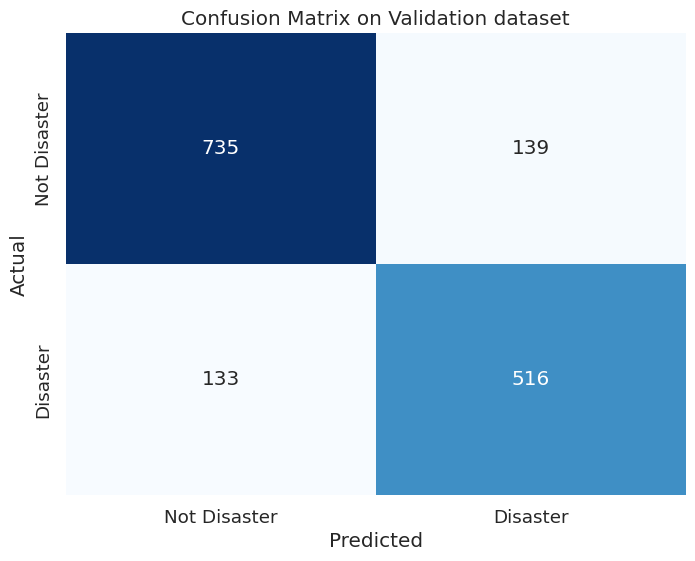

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(val_labels, predictions)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=["Not Disaster","Disaster"],
            yticklabels=["Not Disaster","Disaster"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation dataset')
plt.show()

In [ ]:
Tweets = []
df_test = pd.read_csv("/content/drive/MyDrive/CAPSTONE/testDataset.csv")
for tweet in df_test["Tweet"]:
    Tweets.append(preProcessData(tweet))

In [ ]:
predictions = []
for text in Tweets:
    target = predict_disaster(text, model, tokenizer, device)
    predictions.append(target)

result_df = pd.DataFrame({
    'Tweet': Tweets,
    'class': predictions
})

In [ ]:
result_df['class'].value_counts()

0    3895
1    3809
Name: class, dtype: int64

In [ ]:
result_df

,Tweet,class
0,"PNR : 4258882073 , Train number : 12624 . Can ...",1
1,When can I step out ? It's been 2 days without...,1
2,Still there is no electricity in Karthik stree...,1
3,"friends from Avadi, Pattabhiram and surroundin...",1
4,Dash of Chennai,0
...,...,...
7699,Cheers Charlie,0
7700,"Indiana Brewery Stars Rankings, January 2024 U...",0
7701,Cheers to 4k followers Thank you all.,0
7702,Cheers to those of us that own Alvarez in FPL,0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model, backend, utils
from tensorflow.keras.layers import Layer, LSTM, Bidirectional, Dropout, Input, Embedding, Attention, GlobalAveragePooling1D, Dense, Bidirectional,Conv1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from google.colab import drive

## ***Tokenization***

In [ ]:
Tweets = []
for tweet in train_texts:
    Tweets.append(preProcessData(tweet))

max_text_len = 0
for text in Tweets:
  text = str(text)
  max_text_len = max(len(text.split()), max_text_len)
print(max_text_len)

31


In [ ]:
vocab_size = 10000
oov_tok = "<OOV>"
maxlen = max_text_len
trunc_type="post"
padding_type="post"
embedding_dim = 100 #50

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Tweets, train_labels, test_size=0.15, stratify=train_labels,random_state = 7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,random_state = 7)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,oov_token = oov_tok)

In [ ]:
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index
print(dict(list(words_to_index.items())[:10]))
print(len(words_to_index))

{'<OOV>': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'and': 7, 'i': 8, 'is': 9, 'for': 10}
11836


In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences,
                                maxlen=maxlen,
                                padding=padding_type,
                                truncating = trunc_type)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,
                                maxlen=maxlen,
                                padding=padding_type,
                                truncating = trunc_type)

X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences,
                                maxlen=maxlen,
                                padding=padding_type,
                                truncating = trunc_type)

## ***Glove Function & Parameters***

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [ ]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/CAPSTONE/glove/glove.twitter.27B.50d.txt')

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['password'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))


for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None and index < vocab_len:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len,
                            output_dim=embed_vector_len,
                            input_length=maxlen,
                            weights = [emb_matrix],
                            trainable=False)

## ***Positional Embedding***

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[emb_matrix])
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## ***Defining Multihead Attention Transformer Block***

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=0, mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-6, mode='max')

## ***Plotting Graph***

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## ***LSTM-Multihead Attention Method***

In [ ]:
embed_dim = 50
num_heads = 8
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_len, embed_dim)
x = embedding_layer(inputs)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.7)(x)
x = LSTM(embed_dim, return_sequences=True)(x)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_padded, y_train_np, epochs=50, validation_data=(X_test_padded, y_test_np),
    callbacks=[reduce_lr_acc, earlyStopping]
)

Epoch 1/50
138/138 [==============================] - 27s 109ms/step - loss: 0.5272 - accuracy: 0.7538 - val_loss: 0.4276 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 2/50
138/138 [==============================] - 7s 48ms/step - loss: 0.4293 - accuracy: 0.8222 - val_loss: 0.4730 - val_accuracy: 0.7954 - lr: 0.0010
Epoch 3/50
138/138 [==============================] - 4s 29ms/step - loss: 0.3788 - accuracy: 0.8441 - val_loss: 0.4346 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 4/50
138/138 [==============================] - 3s 21ms/step - loss: 0.3249 - accuracy: 0.8745 - val_loss: 0.4337 - val_accuracy: 0.8085 - lr: 0.0010
Epoch 5/50
138/138 [==============================] - 4s 28ms/step - loss: 0.2701 - accuracy: 0.8995 - val_loss: 0.4572 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 6/50
138/138 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9202
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
138/138 [==============================] - 3s

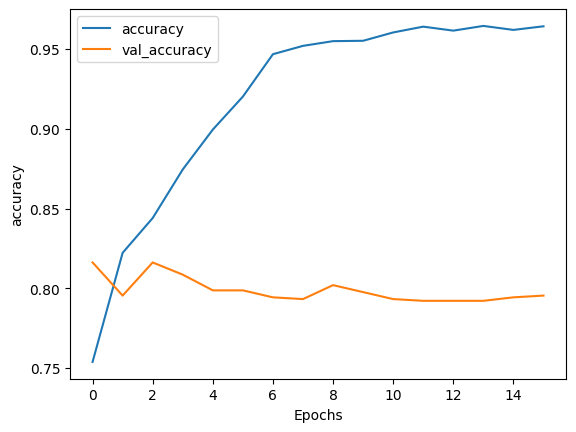

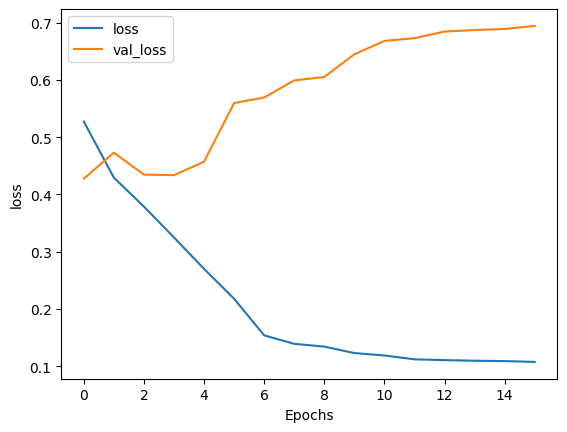

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
y_preds = np.round(model.predict(X_val_padded))
results = calculate_results(y_true= y_val, y_pred=y_preds)
print(results)

25/25 [==============================] - 1s 7ms/step
{'accuracy': 0.7425997425997426, 'precision': 0.7424164054595895, 'recall': 0.7425997425997426, 'f1': 0.7425031208814992}


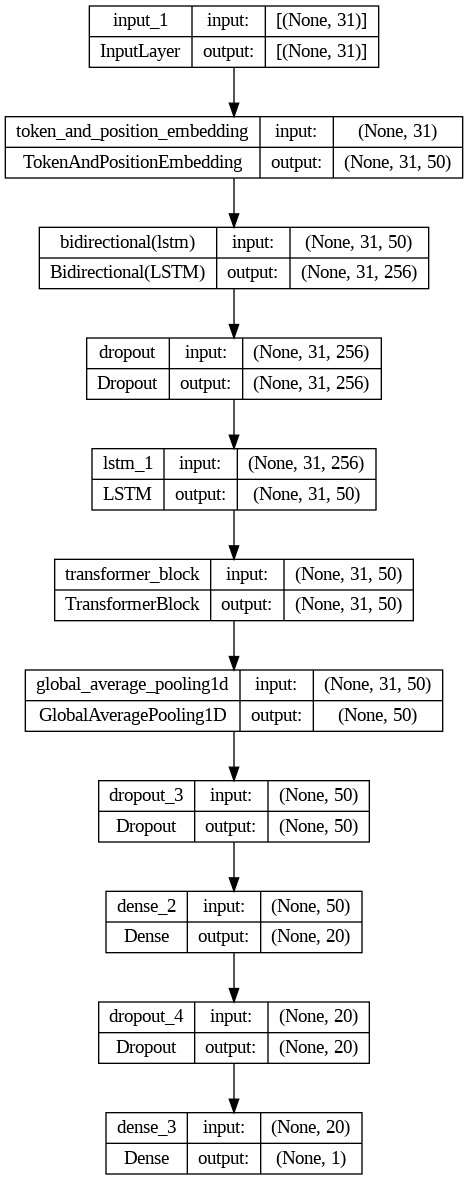

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
Tweets = []
df_test = pd.read_csv("/content/drive/MyDrive/CAPSTONE/testDataset.csv")
for tweet in df_test["Tweet"]:
    Tweets.append(preProcessData(tweet))

In [ ]:
X_val_sequences = tokenizer.texts_to_sequences(Tweets)
X_val_padded = pad_sequences(X_val_sequences,
                                maxlen=maxlen,
                                padding=padding_type,
                                truncating = trunc_type)

In [ ]:
y_preds = np.round(model.predict(X_val_padded))
y_preds = pd.Series(y_preds.flatten())
y_preds.value_counts()

241/241 [==============================] - 2s 7ms/step


0.0    4023
1.0    3681
dtype: int64

In [ ]:
y_preds = y_preds.tolist()

result_df = pd.DataFrame({
    'Tweet': Tweets,
    'class': predictions
})

In [ ]:
result_df

,Tweet,class
0,"PNR : 4258882073 , Train number : 12624 . Can ...",1
1,When can I step out ? It's been 2 days without...,1
2,Still there is no electricity in Karthik stree...,1
3,"friends from Avadi, Pattabhiram and surroundin...",1
4,Dash of Chennai,0
...,...,...
7699,Cheers Charlie,0
7700,"Indiana Brewery Stars Rankings, January 2024 U...",0
7701,Cheers to 4k followers Thank you all.,0
7702,Cheers to those of us that own Alvarez in FPL,0


## ***CNN-LSTM-Multihead Attention Method***

In [ ]:
embed_dim = 50
num_heads = 8
ff_dim = 128

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_len, embed_dim)
x = embedding_layer(inputs)
x = Conv1D(8, 3, padding="same", activation='relu')(x)
x = Dropout(0.5)(x)
#x = MaxPooling1D()(x)
x = Conv1D(16, 3, padding="same", activation='relu')(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.7)(x)
x = LSTM(embed_dim, return_sequences=True)(x)
#x = Dropout(0.7)(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


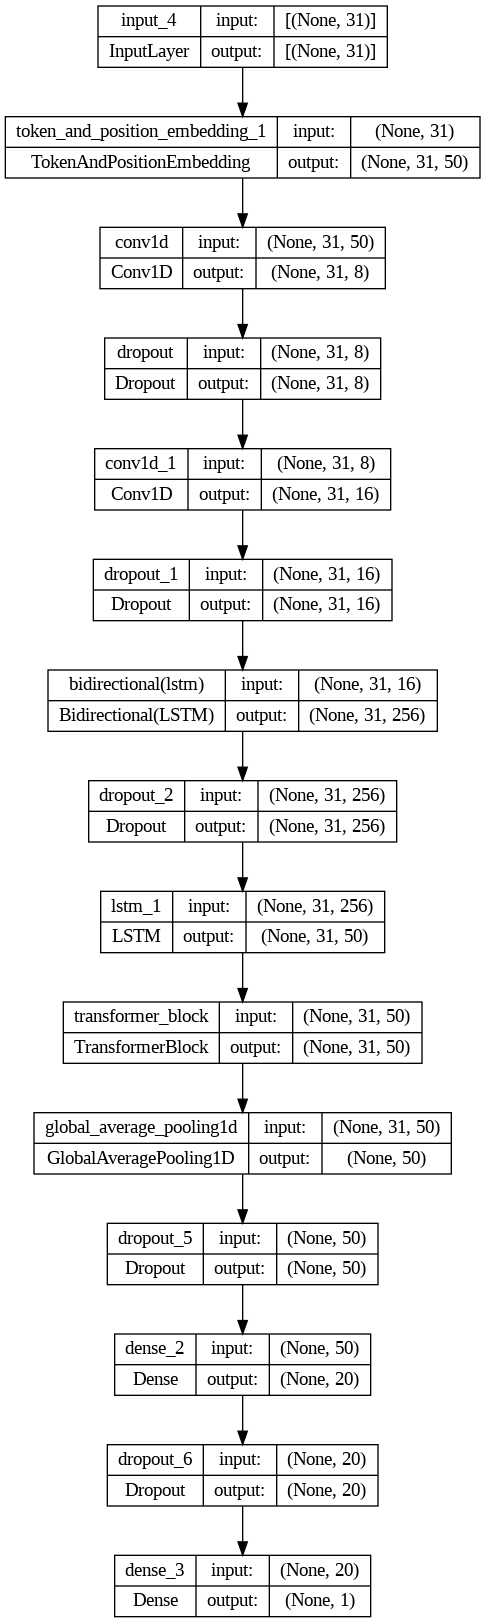

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_padded, y_train_np, epochs=40, validation_data=(X_test_padded, y_test_np),
    callbacks=[reduce_lr_acc, earlyStopping]
)


Epoch 1/40
138/138 [==============================] - 42s 135ms/step - loss: 0.6457 - accuracy: 0.6276 - val_loss: 0.5026 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 2/40
138/138 [==============================] - 6s 43ms/step - loss: 0.5284 - accuracy: 0.7559 - val_loss: 0.4784 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 3/40
138/138 [==============================] - 5s 39ms/step - loss: 0.4758 - accuracy: 0.7915 - val_loss: 0.4370 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 4/40
138/138 [==============================] - 3s 22ms/step - loss: 0.4337 - accuracy: 0.8186 - val_loss: 0.4251 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 5/40
138/138 [==============================] - 3s 22ms/step - loss: 0.3882 - accuracy: 0.8379 - val_loss: 0.4275 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 6/40
138/138 [==============================] - 4s 25ms/step - loss: 0.3477 - accuracy: 0.8559 - val_loss: 0.4203 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 7/40
138/138 [==============================] - 4s 30ms/

In [ ]:
y_preds = np.round(model.predict(X_val_padded))
results = calculate_results(y_true= y_val, y_pred=y_preds)
print(results)

25/25 [==============================] - 0s 7ms/step
{'accuracy': 0.752895752895753, 'precision': 0.7516550967281578, 'recall': 0.752895752895753, 'f1': 0.7512753140761893}


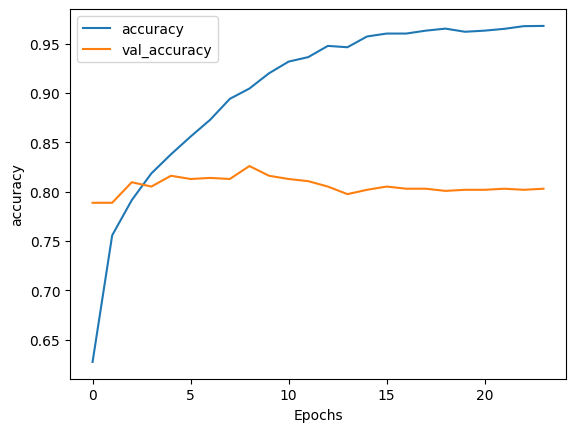

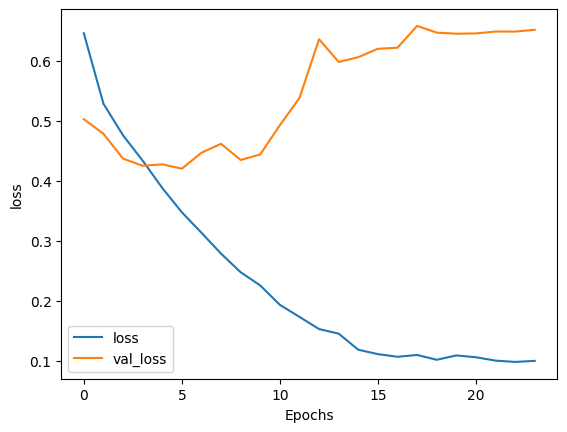

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
!pip install scikeras

## ***Hyperparameter Tuning***

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import MaxPooling1D
from sklearn.metrics import f1_score, recall_score, accuracy_score

In [ ]:
def create_cnn_lstm_multihead_attention_model(units, rate, filters, head, ff):
  embed_dim = 50
  num_heads = head
  ff_dim = ff

  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_len, embed_dim)
  x = embedding_layer(inputs)
  x = Conv1D(filters, 3, padding="same", activation='relu')(x)
  x = Dropout(rate)(x)
  x = MaxPooling1D(3)(x)
  x = Conv1D(2*filters, 3, padding="same", activation='relu')(x)
  x = Dropout(rate)(x)
  x = LSTM(units, return_sequences=True)(x)
  x = Dropout(rate)(x)
  x = LSTM(embed_dim, return_sequences=True)(x)
  x = Dropout(rate)(x)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(20, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
hybrid_model = KerasClassifier(create_cnn_lstm_multihead_attention_model,
                        epochs=15,
                        verbose=1,
                        validation_split=0.2
                        )

In [ ]:
param_grid_hybrid_model = dict(
    model__units = [64, 32, 16],
    model__rate = [0.4, 0.5, 0.6, 0.7],
    model__filters = [8, 16, 32],
    model__head = [4, 6, 8],
    model__ff = [32, 64, 128]
)

In [ ]:
grid_hybrid = RandomizedSearchCV(hybrid_model, param_grid_hybrid_model, cv=4, verbose=1, n_iter=5, scoring="accuracy")

In [ ]:
grid_result_hybrid = grid_hybrid.fit(X_train_padded, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Epoch 1/15
83/83 [==============================] - 18s 110ms/step - loss: 0.6991 - accuracy: 0.5468 - val_loss: 0.6813 - val_accuracy: 0.5803
Epoch 2/15
83/83 [==============================] - 4s 46ms/step - loss: 0.6847 - accuracy: 0.5695 - val_loss: 0.6684 - val_accuracy: 0.5803
Epoch 3/15
83/83 [==============================] - 2s 29ms/step - loss: 0.6657 - accuracy: 0.5945 - val_loss: 0.5764 - val_accuracy: 0.7288
Epoch 4/15
83/83 [==============================] - 2s 26ms/step - loss: 0.6020 - accuracy: 0.6866 - val_loss: 0.5362 - val_accuracy: 0.7409
Epoch 5/15
83/83 [==============================] - 2s 30ms/step - loss: 0.5448 - accuracy: 0.7370 - val_loss: 0.5503 - val_accuracy: 0.7606
Epoch 6/15
83/83 [==============================] - 2s 24ms/step - loss: 0.5340 - accuracy: 0.7582 - val_loss: 0.5629 - val_accuracy: 0.7182
Epoch 7/15
83/83 [==============================] - 2s 19ms/step - loss: 0.5000 - accuracy: 

In [ ]:
print(grid_hybrid.best_score_, grid_hybrid.best_params_)

0.8013175200595583 {'model__units': 32, 'model__rate': 0.7, 'model__head': 8, 'model__filters': 8, 'model__ff': 32}


In [ ]:
best_estimator = grid_result_hybrid.best_estimator_

In [ ]:
best_score = grid_result_hybrid.best_score_
best_score

0.8013175200595583